--- Loaded Data (first 5 rows) ---
   wavelength    efficiency
0    0.931000  2.191901e-09
1    0.931135  1.828837e-09
2    0.931270  9.193326e-10
3    0.931405  4.997221e-10
4    0.931541  1.075342e-09

--- Data Types ---
wavelength    float64
efficiency    float64
dtype: object


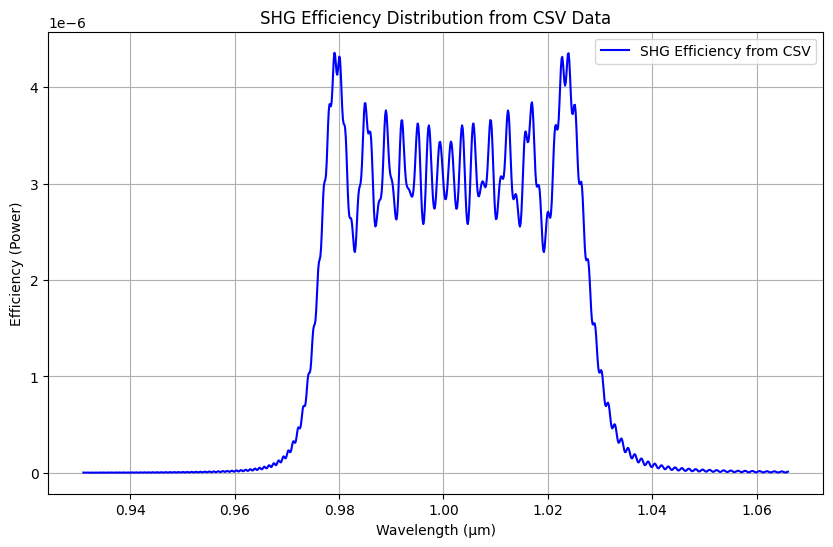

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  # 必要に応じて数値計算用

# --- CSVファイルの読み込み ---
# CSVファイル名を指定（前のスクリプトで出力したファイル名）
csv_filename = 'chirped_shg_efficiency.csv'

# pandasを使ってCSVファイルを読み込む
# header=0 は1行目をヘッダーとして認識させるため（デフォルト）
# encoding='utf-8' は前のスクリプトで指定したエンコーディングに合わせる
df_data = pd.read_csv(csv_filename, header=0, encoding='utf-8')

# データの確認（最初の数行を表示）
print("--- Loaded Data (first 5 rows) ---")
print(df_data.head())
print("\n--- Data Types ---")
print(df_data.dtypes)  # 各列のデータ型を確認

# --- データの抽出 ---
# CSVファイルの列名に合わせてデータを抽出
wavelength_column_name = 'wavelength'
efficiency_column_name = 'efficiency'

if wavelength_column_name not in df_data.columns:
    raise ValueError(
        f"Error: Column '{wavelength_column_name}' not found in {csv_filename}")
if efficiency_column_name not in df_data.columns:
    raise ValueError(
        f"Error: Column '{efficiency_column_name}' not found in {csv_filename}")

wavelengths_loaded = df_data[wavelength_column_name].values
efficiency_loaded = df_data[efficiency_column_name].values

# --- Matplotlibでプロット ---
plt.figure(figsize=(10, 6))  # グラフのサイズを設定

# データをプロット
plt.plot(wavelengths_loaded, efficiency_loaded,  # type: ignore
         color='blue', label='SHG Efficiency from CSV')

# グラフの装飾
plt.xlabel("Wavelength (μm)")  # X軸ラベル
plt.ylabel("Efficiency (Power)")       # Y軸ラベル
plt.title("SHG Efficiency Distribution from CSV Data")  # グラフタイトル
plt.legend()      # 凡例を表示
plt.grid(True)    # グリッドを表示

# 必要に応じてY軸の範囲などを調整
# plt.ylim(0, max(efficiency_loaded) * 1.1) # 例: Y軸の最小値を0、最大値をデータの最大値の1.1倍に

# グラフを表示
plt.show()

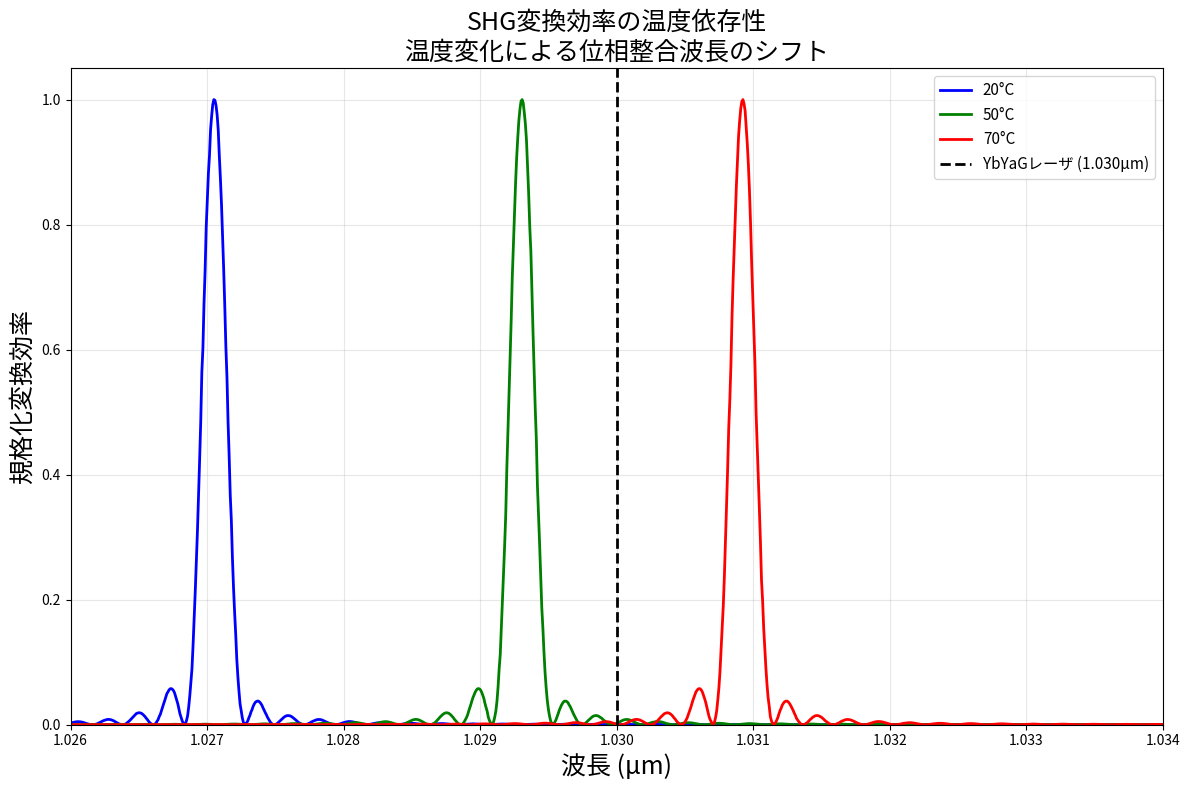

In [10]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from syuron import shg, mgoslt, pp

# 固定グレーティングパラメータ
fixed_grating = pp.fixed(3000, [3.6], 1.031E-05)

# 波長範囲の設定
wavelengths = jnp.linspace(1.026, 1.034, 1000).tolist()
delta_wavelength = wavelengths[1] - wavelengths[0]

# 温度設定
temperatures = [20, 50, 70]
colors = ['blue', 'green', 'red']
labels = ['20°C', '50°C', '70°C']

# YbYaGレーザの波長 (1030nm = 1.030µm)
ybyag_wavelength = 1.030

plt.figure(figsize=(12, 8))

# 各温度での計算とプロット
for i, temp in enumerate(temperatures):
    params = shg.Params(
        grating_dim=fixed_grating,
        T_dim=temp,
        wavelength_dim=wavelengths,
        fund_power_dim=1,
        sh_power_dim=0,
    )

    eff_tensor = (jnp.abs(mgoslt.analyze(params))**2).squeeze()
    eff_tensor = eff_tensor / jnp.max(eff_tensor)

    plt.plot(wavelengths, eff_tensor,
             color=colors[i], linewidth=2, label=labels[i])

# YbYaGレーザの波長に垂直線を追加
plt.axvline(x=ybyag_wavelength, color='black', linestyle='--', linewidth=2,
            label=f'YbYaGレーザ ({ybyag_wavelength:.3f}µm)')

plt.xlabel('波長 (µm)', fontsize=18)
plt.ylabel('規格化変換効率', fontsize=18)
plt.title('SHG変換効率の温度依存性\n温度変化による位相整合波長のシフト', fontsize=18)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.xlim(1.026, 1.034)
plt.ylim(0, 1.05)

plt.tight_layout()
plt.show()